# Meaningful Text Classification  

In [1]:
import pandas as pd
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
%matplotlib inline

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import spacy

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils.class_weight import compute_sample_weight 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict 
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import keras
from keras.layers import Dense, Conv1D, Flatten, Dropout, GlobalMaxPooling1D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [5]:
np.random.seed(101)

In [6]:
# Set plotting styles
sns.set_style('white')  

In [7]:
# Read in raw data and set as a data frame: df1
df1 = pd.read_csv('testProject_About.labeled.csv', header=None)

In [8]:
df1.columns = ['text', 'label', 'source', 'offsets' ]

In [9]:
# df1.info()

In [10]:
# df1.head()

In [11]:
# Read in raw data and set as a data frame: df2
df2 = pd.read_csv('About.train_test_split.csv')

In [12]:
# df2.info()

In [13]:
# df2.head()

In [14]:
df = pd.merge(df1, df2, how='inner', on='source')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16721 entries, 0 to 16720
Data columns (total 5 columns):
text       16721 non-null object
label      16721 non-null object
source     16721 non-null object
offsets    16721 non-null object
set        16721 non-null object
dtypes: object(5)
memory usage: 783.8+ KB


In [16]:
# df.head()

In [17]:
# Drop duplicate rows
df = df.drop_duplicates()

In [18]:
# Balanced dataset?  
df.label.value_counts()

None     14841
About     1880
Name: label, dtype: int64

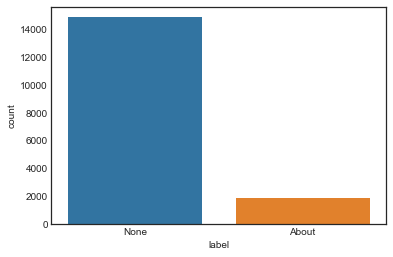

In [19]:
sns.countplot(x="label", data=df)

The 'None' label has a lot more rows than the 'About' row, thus, we need to balance (resample) the data before 
fitting the data to a model.

----

#### Text Pre-processing  

In [20]:
def preprocessing(text):
    """
    Takes in a string, then performs the following:
    1. Make all lower case
    2. Keep only words (remove all punctuations, numbers, etc.)
    3. Remove all stopwords
    4. Lemmatize the remaining words
    5. Join the characters again to form the string
    5. Returns the cleaned text
    """
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    alpha_only = [t for t in lower_tokens if t.isalpha()]  # Retain alphabetic words
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')] # Remove stop words
    wordnet_lemmatizer = WordNetLemmatizer()  # Instantiate the WordNetLemmatizer
    lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]  # Lemmatize all tokens into a new list 
    return ' '.join(lemmatized)

In [21]:
# Apply to df['text'] column
df['clean_text'] = df['text'].apply(preprocessing)

#### Visualize the most common words with label either 'About' or 'None'

In [22]:
# Make a Pandas series with cleaned text whose label is 'About'
series_About = df.loc[df['label']=='About', 'clean_text']  

In [23]:
# Make a Pandas series with cleaned text whose label is 'None'
series_None = df.loc[df['label']=='None', 'clean_text']  

In [24]:
# Make a frequent distribution of the words for the "About" rows
txt = series_About.str.cat(sep=' ')
words = word_tokenize(txt)
word_dist_About = FreqDist(words)

In [25]:
# Make a frequent distribution of the words for the "None" rows
txt = series_None.str.cat(sep=' ')
words = word_tokenize(txt)
word_dist_None = FreqDist(words)

In [26]:
# Get the top 20 most common words with "About" label:
count_About = Counter(word_dist_About).most_common(20)  

In [27]:
# Get the top 20 most common words with "None" label:
count_None = Counter(word_dist_None).most_common(20)  

In [28]:
names, values = zip(*count_About)

In [29]:
d = {'names': names, 'values': values}
df_About = pd.DataFrame(data=d)

Text(0,0.5,'Count')

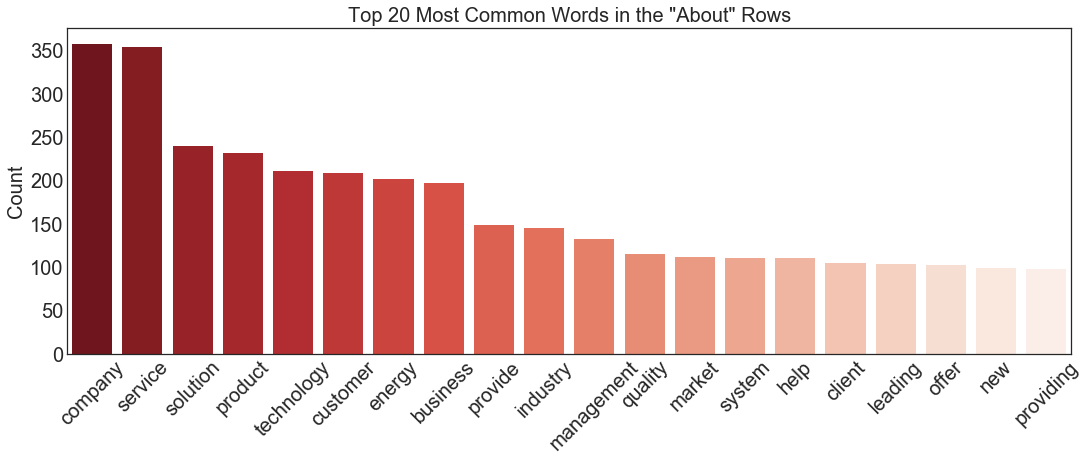

In [30]:
plt.figure(figsize=(18, 6))
sns.barplot(x='names', y='values', data=df_About, palette='Reds_r')
plt.title('Top 20 Most Common Words in the "About" Rows', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ') 
plt.ylabel('Count', fontsize=20)

In [31]:
names, values = zip(*count_None)

In [32]:
d = {'names': names, 'values': values}
df_None = pd.DataFrame(data=d)

Text(0,0.5,'Count')

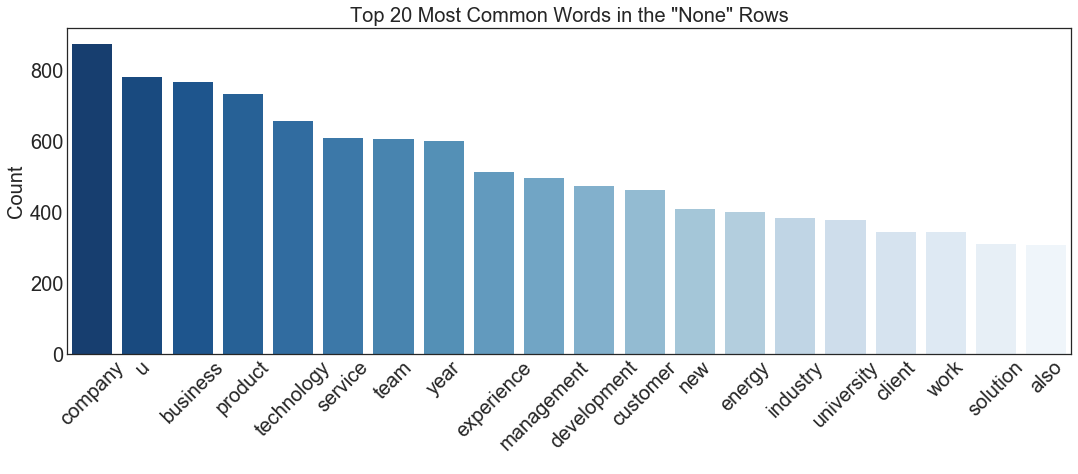

In [33]:
plt.figure(figsize=(18, 6))
sns.barplot(x='names', y='values', data=df_None, palette='Blues_r')
plt.title('Top 20 Most Common Words in the "None" Rows', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ') 
plt.ylabel('Count', fontsize=20)

In [34]:
# Combine the two dataframes
df_combined = pd.concat([df_About, df_None], axis=1)

In [35]:
df_combined.columns = ['About words', 'frequency', 'None words', 'frequency']

In [36]:
df_combined

,About words,frequency,None words,frequency
0,company,358,company,876
1,service,354,u,781
2,solution,240,business,768
3,product,232,product,733
4,technology,211,technology,658
5,customer,209,service,611
6,energy,202,team,608
7,business,197,year,602
8,provide,149,experience,513
9,industry,146,management,496


As you can see, the word lists are quite similar.  
This makes classification harder to do...

----
##### Feature Engineer the length column

In [37]:
df['length'] = df['text'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a29e3ad30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a29ef1710>], dtype=object)

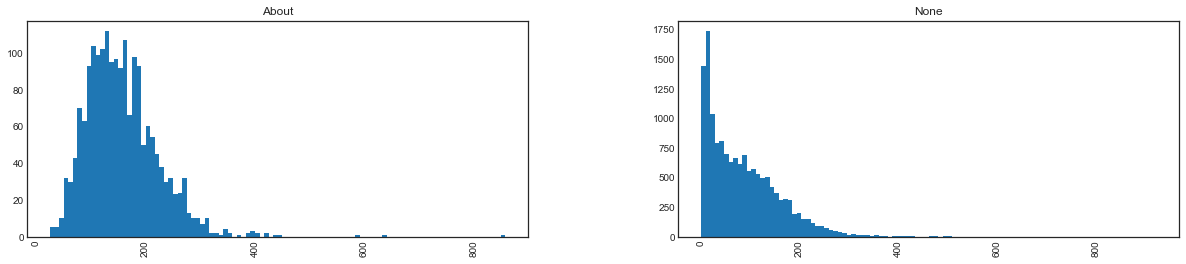

In [38]:
# Compare Taxt length of the two classes:
df.hist(column='length', by='label', bins=100, figsize=(20,4))

----

##### Feature Engineer Named Entity column:

In [39]:
# Instantiate the English model: nlp
nlp = spacy.load('en', tagger=False, parser=False, matcher=False)

In [40]:
def tag_entity(text):
    doc = nlp(text)
    ents = [ent for ent in list(doc.ents) if ent.label_ == 'NORP' or ent.label_ == 'FAC' or ent.label_ == 'ORG' or ent.label_ == 'PRODUCT']
    return ents 

#### Named entity List:
![title](Named_Entity_list.png)

In [41]:
df['named_entity'] = df['text'].apply(tag_entity)

In [42]:
def preprocessing_light(lst):
    text = str(lst)
    tokens = word_tokenize(text)
    alpha_only = [t for t in tokens if t.isalpha()]
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')]
    return ' '.join(no_stops)

In [43]:
df['named_entity'] = df['named_entity'].apply(preprocessing_light)

In [44]:
# replace white_space with 'a'
df['named_entity'] = df['named_entity'].replace(r'^\s*$', 'a', regex=True)

----
##### Use count_vectorizer and tfidf_vectorizer to transform text into numerical matrix

In [45]:
# # NOTE: Both X and y must be series to use count_vectorizer and tfidf_vectorizer.
# X = df['clean_text']
# y = df.label

In [46]:
X_train = df.loc[df['set']=='train', 'clean_text']  
y_train = df.loc[df['set']=='train', 'label']  
X_test = df.loc[df['set']=='test', 'clean_text']  
y_test = df.loc[df['set']=='test', 'label']  

In [47]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

In [48]:
# Transform the training data using only the 'text' column values: count_train 
count_train = count_vectorizer.fit_transform(X_train)

In [49]:
# Transform the test data using only the 'text' column values: count_test 
count_test = count_vectorizer.transform(X_test)

----
 

In [50]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

In [51]:
# Transform the training data: tfidf_train 
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [52]:
# Transform the test data: tfidf_test 
tfidf_test = tfidf_vectorizer.transform(X_test)

---

##### 1st attempt to train the model: only use the 'clean_text' column with CountVectorizer and TfidfVectorizer

In [53]:
nb_classifier = MultinomialNB()

In [54]:
# Estimate sample weights by class for unbalanced datasets
sample_weight = compute_sample_weight('balanced', y_train) 

In [55]:
# Fit the classifier to the training data
nb_classifier.fit(count_train, y_train, sample_weight=sample_weight)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [56]:
# Create the predicted tags: pred
pred = nb_classifier.predict(count_test)

In [57]:
# Confusion_matrix
print(confusion_matrix(y_test, pred))

[[ 288   88]
 [ 836 2132]]


In [58]:
# Classification table
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      About       0.26      0.77      0.38       376
       None       0.96      0.72      0.82      2968

avg / total       0.88      0.72      0.77      3344



Precision rate is very low for predicting the 'About' class. Not good.

---
Now, use tfidf:

In [59]:
# Create a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB()

In [60]:
# Estimate sample weights by class for unbalanced datasets
sample_weight = compute_sample_weight('balanced', y_train) 

In [61]:
# Fit the classifier to the training data
nb_classifier.fit(tfidf_train, y_train, sample_weight=sample_weight)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [62]:
# Create the predicted tags: pred
pred = nb_classifier.predict(tfidf_test)

In [63]:
# Classification table
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      About       0.24      0.85      0.37       376
       None       0.97      0.66      0.78      2968

avg / total       0.89      0.68      0.74      3344



Not surprisingly, the precision rate is still very low.

----
##### Feature importance:

In [64]:
# Get the class labels: class_labels
class_labels = nb_classifier.classes_

In [65]:
# Extract the features: feature_names
feature_names = tfidf_vectorizer.get_feature_names()

In [66]:
# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

In [67]:
# Print the first class label ('About') and the top 20 feat_with_weights entries
print(class_labels[0], feat_with_weights[:20])

About [(-10.263992036084902, 'aardvarkcompare'), (-10.263992036084902, 'aberdeen'), (-10.263992036084902, 'acai'), (-10.263992036084902, 'acceptance'), (-10.263992036084902, 'accompanied'), (-10.263992036084902, 'accountably'), (-10.263992036084902, 'acoem'), (-10.263992036084902, 'adapter'), (-10.263992036084902, 'adgero'), (-10.263992036084902, 'administer'), (-10.263992036084902, 'adolescent'), (-10.263992036084902, 'advertisement'), (-10.263992036084902, 'aeroplane'), (-10.263992036084902, 'afford'), (-10.263992036084902, 'agendia'), (-10.263992036084902, 'aggregator'), (-10.263992036084902, 'agnostic'), (-10.263992036084902, 'agribusiness'), (-10.263992036084902, 'agrochemical'), (-10.263992036084902, 'aic')]


In [68]:
About_features = feat_with_weights[:20]

In [69]:
About_features

[(-10.263992036084902, 'aardvarkcompare'),
 (-10.263992036084902, 'aberdeen'),
 (-10.263992036084902, 'acai'),
 (-10.263992036084902, 'acceptance'),
 (-10.263992036084902, 'accompanied'),
 (-10.263992036084902, 'accountably'),
 (-10.263992036084902, 'acoem'),
 (-10.263992036084902, 'adapter'),
 (-10.263992036084902, 'adgero'),
 (-10.263992036084902, 'administer'),
 (-10.263992036084902, 'adolescent'),
 (-10.263992036084902, 'advertisement'),
 (-10.263992036084902, 'aeroplane'),
 (-10.263992036084902, 'afford'),
 (-10.263992036084902, 'agendia'),
 (-10.263992036084902, 'aggregator'),
 (-10.263992036084902, 'agnostic'),
 (-10.263992036084902, 'agribusiness'),
 (-10.263992036084902, 'agrochemical'),
 (-10.263992036084902, 'aic')]

In [70]:
weights, words = zip(*About_features)

In [71]:
d = {'weigts': weights, 'words': words}
df_About_features = pd.DataFrame(data=d)

Text(0,0.5,'Weight')

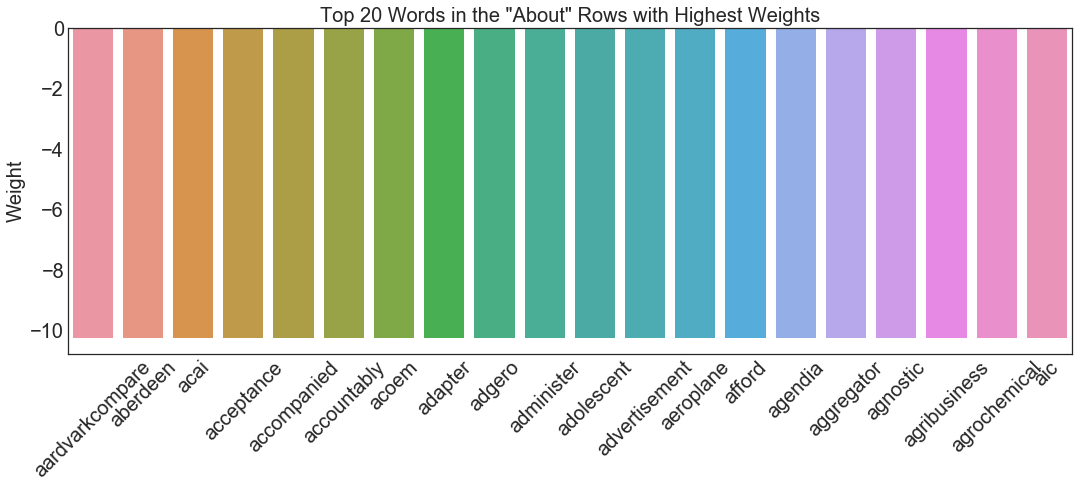

In [72]:
plt.figure(figsize=(18, 6))
sns.barplot(x='words', y='weigts', data=df_About_features)
plt.title('Top 20 Words in the "About" Rows with Highest Weights', fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(' ') 
plt.ylabel('Weight', fontsize=20)

----

##### 2nd attempt to train the model: use feature-engineered columns and a pipe containing PCA and random forest model:

In [73]:
X_train = df.loc[df['set']=='train', 'named_entity']  
y_train = df.loc[df['set']=='train', 'label']  
X_test = df.loc[df['set']=='test', 'named_entity']  
y_test = df.loc[df['set']=='test', 'label']  

In [74]:
tfidf_vectorizer = TfidfVectorizer()

In [75]:
# Transform the training data:  
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

In [76]:
# Transform the test data:  
tfidf_test = tfidf_vectorizer.transform(X_test)

In [77]:
# Create the tfidf_train DataFrame:  
df_tfidf_train = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

In [78]:
df_length_train = df.loc[df['set']=='train', ['length']]
df_length_test = df.loc[df['set']=='test', ['length']] 

In [79]:
df_length_train = df_length_train.reset_index(drop=True)

In [80]:
X_train = pd.concat([df_tfidf_train, df_length_train], axis=1)

In [81]:
# Create the tfidf_test DataFrame:  
df_tfidf_test = pd.DataFrame(tfidf_test.A, columns=tfidf_vectorizer.get_feature_names())

In [82]:
df_length_test = df_length_test.reset_index(drop=True)

In [83]:
X_test = pd.concat([df_tfidf_test, df_length_test], axis=1)

In [84]:
# Note: may be easier to convert all df's to matrices then use mat_A.hstack(mat_B) to combine the two matrices together.


----

In [85]:
# Make a pipeline
pipe = make_pipeline(StandardScaler(), PCA(random_state=101), RandomForestClassifier(random_state=101))  
pipe

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
  svd_solver='auto', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, c...timators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [86]:
# Note: I don't seem to have enough CPU power to do grid search.

In [87]:
# param_grid = dict(pca__n_components=[10,20,30], randomforestclassifier__n_estimators=[10,20,30])

In [88]:
# grid = GridSearchCV(pipe, param_grid=param_grid, verbose=2, n_jobs=-1)
# grid.fit(X_train, y_train)

In [89]:
smo = SMOTE()
X_resampled, y_resampled = smo.fit_sample(X_train, y_train)

In [90]:
pipe.fit(X_resampled, y_resampled) 

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=101,
  svd_solver='auto', tol=0.0, whiten=False)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, c...timators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [91]:
# Create the predicted tags: pred
pred = pipe.predict(X_test)

In [92]:
# Classification table
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      About       0.24      0.43      0.31       376
       None       0.92      0.83      0.87      2968

avg / total       0.84      0.78      0.81      3344



Still bad on precision rate.   

Ideas:   
- train on the clean_text columns and the new engineered columns together.
- use RandomizedSearchCV( ) or GridSearchCV( ) to get optimal hyperparameters. 
- (no computing power to do so on my laptop)

----
##### 3rd attempt to train the model: use deep learning (neural networks)

##### Use count_vectorizer to transform text into numerical matrix

In [93]:
# Remind myself what df looks like:
# df.head(1)

In [94]:
# Change target label to binary values
df.loc[df['label']=='About', 'label'] = 1
df.loc[df['label']=='None', 'label'] = 0

In [95]:
# Train test split
X_train = df.loc[df['set']=='train', 'clean_text']  
y_train = df.loc[df['set']=='train', 'label']  
X_test = df.loc[df['set']=='test', 'clean_text']  
y_test = df.loc[df['set']=='test', 'label']  

In [96]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

In [97]:
# Transform the training data using only the 'text' column values: count_train 
X_count_train = count_vectorizer.fit_transform(X_train)

In [98]:
# Transform the test data using only the 'text' column values: count_test 
X_count_test = count_vectorizer.transform(X_test)

In [99]:
# change to an array
X_count_train = X_count_train.A
X_count_test = X_count_test.A

In [100]:
# change to an array
y_train = y_train.values
y_test = y_test.values

In [101]:
# Convert the target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#### Note: since the multiple nodes in the hidden layers take care of the interactions between features, we don't need to do much feature engineering.

In [102]:
n_cols = X_count_train.shape[1]

In [103]:
input_shape = (n_cols,)

In [104]:
# input_shape

In [105]:
# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = input_shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [106]:
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [107]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

In [108]:
# Fit the model
sgd_model = model.fit(X_count_train, y_train, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor], class_weight = 'balanced')


Train on 9363 samples, validate on 4014 samples
Epoch 1/30
9363/9363 [==============================] - 6s 667us/step - loss: 0.4217 - acc: 0.8850 - val_loss: 0.3615 - val_acc: 0.8814
Epoch 2/30
9363/9363 [==============================] - 5s 557us/step - loss: 0.3388 - acc: 0.8902 - val_loss: 0.3515 - val_acc: 0.8814
Epoch 3/30
9363/9363 [==============================] - 5s 542us/step - loss: 0.3283 - acc: 0.8902 - val_loss: 0.3407 - val_acc: 0.8814
Epoch 4/30
9363/9363 [==============================] - 5s 535us/step - loss: 0.3162 - acc: 0.8902 - val_loss: 0.3280 - val_acc: 0.8814
Epoch 5/30
9363/9363 [==============================] - 6s 647us/step - loss: 0.3020 - acc: 0.8902 - val_loss: 0.3140 - val_acc: 0.8814
Epoch 6/30
9363/9363 [==============================] - 5s 572us/step - loss: 0.2863 - acc: 0.8902 - val_loss: 0.3002 - val_acc: 0.8827
Epoch 7/30
9363/9363 [==============================] - 5s 569us/step - loss: 0.2710 - acc: 0.8916 - val_loss: 0.2886 - val_acc: 0.8842


In [109]:
model.save('model_sgd.h5')

In [110]:
# Evaluate the model with (valuation_loss, valuation_accuracy):
model.evaluate(X_count_test,y_test)

3344/3344 [==============================] - 1s 240us/step


[0.24404026015380922, 0.89772727272727271]

In [111]:
predictions = model.predict(X_count_test)

In [112]:
predictions

array([[ 0.940997  ,  0.05900303],
       [ 0.9709838 ,  0.02901615],
       [ 0.9735744 ,  0.02642557],
       ..., 
       [ 0.87491274,  0.12508725],
       [ 0.98084098,  0.01915901],
       [ 0.99309158,  0.00690838]], dtype=float32)

In [113]:
# Convert predictions from probability to classification 
predictions_binary = (predictions >= 0.5).astype(np.int)

In [114]:
# Classification table
print(classification_report(y_test, predictions_binary))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94      2968
          1       0.57      0.39      0.46       376

avg / total       0.88      0.90      0.89      3344



Text(0.5,0,'Epochs')

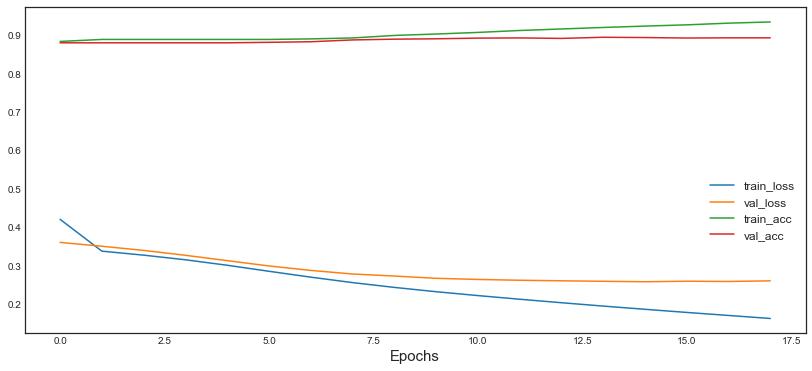

In [115]:
# visualizing losses and accuracy
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['acc']
val_acc    = model.history.history['val_acc']

plt.figure(figsize=(14,6))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5), fontsize = 'large')
plt.xlabel('Epochs', fontsize=15)

Improved precision rate compared to previous models I trained.        
Can play around with inputs to see if we can get better results.  
- add regularization: model.add(Dropout(0.2)) 
- try different activation functions
- try optimizer='adam'? Try different optimizers
- more nodes, more hidden layers
- find optimal learning rate

----
#### Find the best learning rate:

In [116]:
def get_new_model(input_shape = input_shape):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return(model)

In [117]:
# Create list of learning rates: lr_to_test
lr_to_test = [.000001, 0.01, 1]

# Loop over learning rates
for lr in lr_to_test:
    print('\n\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = get_new_model()
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Define early_stopping_monitor
    early_stopping_monitor = EarlyStopping(patience=2)
    
    # Fit the model
    sgd_model = model.fit(X_count_train, y_train, epochs=30, validation_split=0.3,  verbose=0, callbacks=[early_stopping_monitor])

    # Make predictions
    predictions = model.predict(X_count_test)
    
    
    # Convert predictions from probability to classification 
    predictions_binary = (predictions >= 0.5).astype(np.int)

    # Classification table
    print(classification_report(y_test, predictions_binary))




Testing model with learning rate: 0.000001

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      2968
          1       0.16      0.13      0.14       376

avg / total       0.81      0.82      0.82      3344




Testing model with learning rate: 0.010000

             precision    recall  f1-score   support

          0       0.92      0.96      0.94      2968
          1       0.57      0.37      0.45       376

avg / total       0.88      0.90      0.89      3344




Testing model with learning rate: 1.000000

             precision    recall  f1-score   support

          0       0.92      0.95      0.94      2968
          1       0.48      0.36      0.41       376

avg / total       0.87      0.88      0.88      3344



It seems that learning rate= 0.01 did the best.

----
##### 4th attempt to train the model: use deep learning (CNN - convolutional neural networks)

In [118]:
# reshape X_count_train from 2D array to 3D array:
X_count_train = X_count_train.reshape(X_count_train.shape[0], X_count_train.shape[1], 1)
print(X_count_train.shape)

(13377, 13029, 1)


In [119]:
# reshape X_count_test from 2D array to 3D array:
X_count_test = X_count_test.reshape(X_count_test.shape[0], X_count_test.shape[1], 1)
print(X_count_test.shape)

(3344, 13029, 1)


In [120]:
# note: kernel_size: the length of the 1D convolution window.

In [121]:
model = Sequential()

# Add a convolutional layer (15 units)
model.add(Conv1D(15, kernel_size=2, activation='relu', 
                 input_shape=(X_count_train.shape[1], 1)))

# Add a dropout layer (regularization)
model.add(Dropout(0.2))
              
# Add another convolutional layer (5 units)
model.add(Conv1D(5, kernel_size=2, activation='relu'))

# Add a dropout layer (regularization)
model.add(Dropout(0.2))

# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

# Summarize the model 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 13028, 15)         45        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13028, 15)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13027, 5)          155       
_________________________________________________________________
dropout_2 (Dropout)          (None, 13027, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65135)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 130272    
Total params: 130,472
Trainable params: 130,472
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [123]:
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)

In [124]:
# Fit the model to training data 
cnn_model = model.fit(X_count_train, y_train, epochs=30, validation_split=0.3, callbacks=[early_stopping_monitor])

Train on 9363 samples, validate on 4014 samples
Epoch 1/30
9363/9363 [==============================] - 93s 10ms/step - loss: 0.3176 - acc: 0.8903 - val_loss: 0.3499 - val_acc: 0.8767
Epoch 2/30
9363/9363 [==============================] - 68s 7ms/step - loss: 0.2011 - acc: 0.9226 - val_loss: 0.3076 - val_acc: 0.8946
Epoch 3/30
9363/9363 [==============================] - 68s 7ms/step - loss: 0.1347 - acc: 0.9475 - val_loss: 0.3771 - val_acc: 0.8916
Epoch 4/30
9363/9363 [==============================] - 73s 8ms/step - loss: 0.0955 - acc: 0.9650 - val_loss: 0.4246 - val_acc: 0.8804
Epoch 5/30
9363/9363 [==============================] - 73s 8ms/step - loss: 0.0693 - acc: 0.9755 - val_loss: 0.5044 - val_acc: 0.8792


In [125]:
# Evaluate the model on test data: (valuation_loss, valuation_accuracy):
model.evaluate(X_count_test,y_test)

3344/3344 [==============================] - 8s 2ms/step


[0.43978000297233388, 0.88726076555023925]

In [126]:
predictions = model.predict(X_count_test)

In [127]:
predictions

array([[  9.85484898e-01,   1.45151019e-02],
       [  8.81630838e-01,   1.18369147e-01],
       [  9.96737421e-01,   3.26254382e-03],
       ..., 
       [  2.59501133e-02,   9.74049866e-01],
       [  9.88036156e-01,   1.19638480e-02],
       [  9.99997139e-01,   2.91911715e-06]], dtype=float32)

In [128]:
# Convert predictions from probability to classification 
predictions_binary = (predictions >= 0.5).astype(np.int)

In [129]:
# Classification table
print(classification_report(y_test, predictions_binary))

             precision    recall  f1-score   support

          0       0.93      0.95      0.94      2968
          1       0.50      0.41      0.45       376

avg / total       0.88      0.89      0.88      3344



Text(0.5,0,'Epochs')

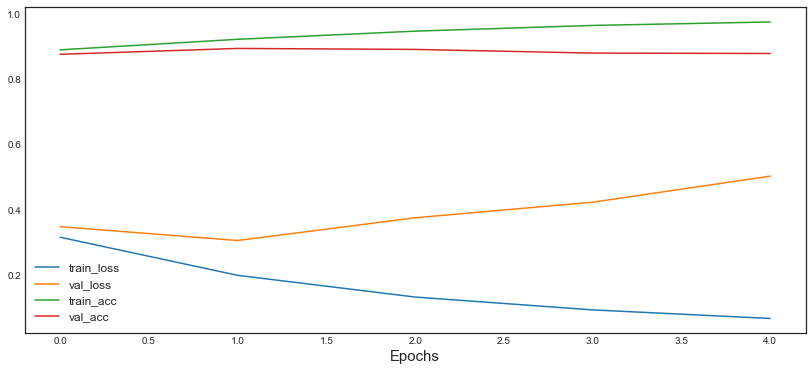

In [130]:
# visualizing losses and accuracy
train_loss = model.history.history['loss']
val_loss   = model.history.history['val_loss']
train_acc  = model.history.history['acc']
val_acc    = model.history.history['val_acc']

plt.figure(figsize=(14,6))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='best', fontsize = 'large')
plt.xlabel('Epochs', fontsize=15)

Looks like the model is over-fitted. Need to decrease the number of epochs.

----
### Are the labels for the target column accurate?
If the labels for the target column are not accurate, it's not a good idea to use supervised learning algorithm.   
Instead, let's use an unsupervised learning algorithm K Mean Clastering to classify the data.   


##### 5th attempt to train the model: use unsupervised learning K-Mean Clustering:

In [131]:
# NOTE: Both X and y must be series in order to use count_vectorizer and tfidf_vectorizer.
X = df['clean_text']
y = df.label

In [132]:
# Initialize a CountVectorizer object: count_vectorizer
count_vectorizer = CountVectorizer(stop_words='english')

In [133]:
# Transform the training data using only the 'text' column values: count_train 
X_count_train = count_vectorizer.fit_transform(X)

In [134]:
# change to an array
X_count_train = X_count_train.A

In [135]:
# change y from pd.series to an array, also change dtype to 'int32'
y = y.values
y = y.astype('int32')

In [136]:
y

array([0, 1, 1, ..., 0, 0, 0], dtype=int32)

In [137]:
kmeans = KMeans(n_clusters=2, random_state=101)

In [138]:
kmeans.fit(X_count_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=101, tol=0.0001, verbose=0)

In [139]:
# Cluster center vectors (2 only since n_clusters=2 )
kmeans.cluster_centers_

array([[ -6.41034534e-18,   2.70507879e-04,   6.76269696e-05, ...,
         -6.41034534e-18,  -6.41034534e-18,   6.76269696e-05],
       [  5.17063082e-04,   9.62229428e-18,   2.40557357e-18, ...,
          5.17063082e-04,   5.17063082e-04,   2.40557357e-18]])

Evaluation:  

There is no perfect way to evaluate clustering if we don't have the labels.     
However since we have the labels,  we can evaluate our clusters.       
( Keep in mind, we won't have this luxury in the real world. )


In [140]:
print(confusion_matrix(y,kmeans.labels_))
print(classification_report(y,kmeans.labels_))

[[13500  1341]
 [ 1287   593]]
             precision    recall  f1-score   support

          0       0.91      0.91      0.91     14841
          1       0.31      0.32      0.31      1880

avg / total       0.84      0.84      0.84     16721



Ok, the K-Mean Clustering model didn't fit well. At least with this try.    
But again, if the labels are not accurate, we don't know whether the model fits well or not...

----
### Conclusion:
Of all the models I fitted and evaluated, the Neural Networks model did the best.   
Therefore, we should focus our energy on fine-tuning the Neural Networks model.
